-0.2 0.2


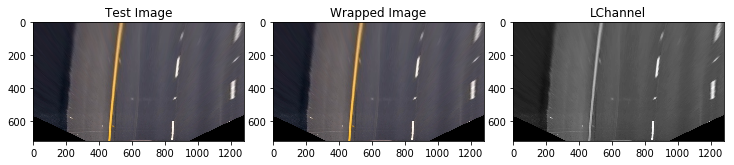

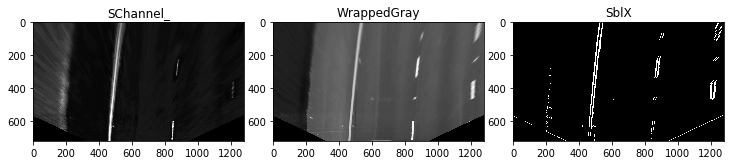

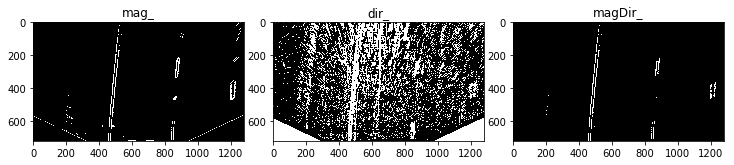

In [13]:
import os
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

######################### DEFINES ##############################
def getHLSChannelImages(image):
    hlsImg = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hlsImg[:,:,0]
    L = hlsImg[:,:,1]
    S = hlsImg[:,:,2]
    return H, L, S

def absSobelXTreshold(grayimg, kernelSize=7, tLow=0, tHigh=255):
    img = np.copy(grayimg)
    #Take the derivative in x 
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    #Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= tLow) & (scaled_sobel <= tHigh)] = 1
    
    return sxbinary

def magSobelThreshold(grayimg, kernelSize=7, tLow=0, tHigh=255):
    img = np.copy(grayimg)
    # Apply the following steps to img
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0) #x
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1) #y
    # Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= tLow) & (scaled_sobel <= tHigh)] = 1
    
    return sxbinary

def directionalSobelThreshold(grayimg, kernelSize=7, tLow=0, tHigh=np.pi/2):
    img = np.copy(grayimg)
    # Take the gradient in x and y separately
    sblX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernelSize)
    sblY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernelSize)
    # Take the absolute value of the x and y gradients
    AsblX = np.absolute(sblX)
    AsblY = np.absolute(sblY)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctXY = np.arctan2(AsblY, AsblX)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arctXY)    
    # Return this mask as your binary_output image
    binary_output[(arctXY >= tLow) & (arctXY <= tHigh)] = 1
    return binary_output
    

def displayImages(imgs, cmap=None, ImgTitles=None):
    numImg = len(imgs)
    
    #calculate number of rows for 2 columns of images
    #define columns 2
    nCols = 3
    nRows, bal = divmod(numImg, nCols)
    if bal > 0:
        nRows += 1
    
    #plt.figure(figsize=(12, 30))
    plt.figure(figsize=(10,30))
    for i, image in enumerate(imgs):
        if ImgTitles==None:
            plt.subplot(nRows, nCols, i+1)
        else:
            plt.subplot(nRows, nCols, i+1, title=ImgTitles[i])        
            
        plt.imshow(image, cmap = cmap)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    return
######################### DEFINES ##############################

testImgR = mpimg.imread('mptestimage.jpg')

TestImgs = []
TestNames = []
testImg = np.copy(testImgR)

#Ignore this extra copy
TestImgs.append(testImgR)
TestNames.append('Test Image')


TestImgs.append(testImg)
TestNames.append('Wrapped Image')
H, L, S = getHLSChannelImages(testImg)
TestImgs.append(L)
TestNames.append("LChannel")
TestImgs.append(S)
TestNames.append("SChannel_")
        
#get the gray scale image for the wrapped image
grayimg = cv2.cvtColor(testImg, cv2.COLOR_RGB2GRAY)
TestImgs.append(grayimg)
TestNames.append('WrappedGray')

        
#Sobel abs x Threshold
tLow  = 20
tHigh = 100
scaledSblx = absSobelXTreshold(grayimg, kernelSize=13, tLow=tLow, tHigh=tHigh)
TestImgs.append(scaledSblx)
TestNames.append("SblX")

#Sobel magnitude threshold
tLow  = 20
tHigh = 200 
magSbl = magSobelThreshold(grayimg, kernelSize=13, tLow=tLow, tHigh=tHigh)
TestImgs.append(magSbl)
TestNames.append("mag_")

#Sobel directional threshold
tLow  = -0.2 #np.pi/6
tHigh = 0.2 #0.9 #np.pi/2
print(tLow, tHigh)
dirSbl = directionalSobelThreshold(grayimg, kernelSize=21, tLow=tLow, tHigh=tHigh)

TestImgs.append(dirSbl)
TestNames.append("dir_")

magDirCombinedImg = np.zeros_like(magSbl)
magDirCombinedImg[((magSbl == 1) & (dirSbl == 1))] = 1

TestImgs.append(magDirCombinedImg)
TestNames.append("magDir_")

displayImages(TestImgs[0:3], cmap='gray', ImgTitles=TestNames[0:3])
displayImages(TestImgs[3:6], cmap='gray', ImgTitles=TestNames[3:6])
displayImages(TestImgs[6:9], cmap='gray', ImgTitles=TestNames[6:9])